In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
np.random.seed(0)

cubagem_data = pd.DataFrame({

    'ID do Pacote': range(1, 101),
    'Peso': np.random.uniform(1, 50, 100),
    'Altura': np.random.uniform(10, 100, 100),
    'Largura': np.random.uniform(10, 100, 100),
    'Profundidade': np.random.uniform(10, 100, 100),
    'Tipo de Produto': np.random.choice(['Eletrônicos', 'Farmacêuticos', 'Vestuário'], 100),
    'Fragilidade': np.random.choice([True, False], 100),
    'ID do Veículo': np.random.choice(['V1', 'V2', 'V3'], 100),
    'Capacidade do Veículo': np.random.choice([200, 300, 400], 100)

})


# Gerar dados para otimização do tamanho de embalagens

np.random.seed(1)

embalagens_data = pd.DataFrame({

    'ID do Produto': range(1, 101),
    'Altura': np.random.uniform(5, 50, 100),
    'Largura': np.random.uniform(5, 50, 100),
    'Profundidade': np.random.uniform(5, 50, 100),
    'Peso do Produto': np.random.uniform(0.5, 25, 100),
    'Material de Embalagem': np.random.choice(['Papelão', 'Plástico', 'Isopor'], 100),
    'Custo por Unidade de Material': np.random.uniform(0.1, 1.0, 100),
    'Volume de Vendas': np.random.randint(100, 1000, 100)

})


# Gerar dados para eficiência na rota de entregas

np.random.seed(2)

entregas_data = pd.DataFrame({

    'ID da Entrega': range(1, 101),
    'ID do Veículo': np.random.choice(['V1', 'V2', 'V3', 'V4'], 100),
    'Local de Partida': np.random.choice(['CD1', 'CD2', 'CD3'], 100),
    'Destino da Entrega': np.random.choice(['Local A', 'Local B', 'Local C', 'Local D', 'Local E'], 100),
    'Distância': np.random.uniform(10, 300, 100),  # Distância em km
    'Tempo Estimado de Viagem': np.random.uniform(30, 240, 100),  # Tempo em minutos
    'Condições de Tráfego': np.random.choice(['Baixo', 'Médio', 'Alto'], 100)

})


# Exibir os primeiros registros

print("Embalagens Data:")
print(embalagens_data.head().to_markdown(index=False))

print("\nCubagem Data:")
print(cubagem_data.head().to_markdown(index=False))

print("\nEntregas Data:")
print(entregas_data.head().to_markdown(index=False))

Embalagens Data:
|   ID do Produto |   Altura |   Largura |   Profundidade |   Peso do Produto | Material de Embalagem   |   Custo por Unidade de Material |   Volume de Vendas |
|----------------:|---------:|----------:|---------------:|------------------:|:------------------------|--------------------------------:|-------------------:|
|               1 | 23.766   |   19.699  |        47.7579 |           20.3905 | Papelão                 |                        0.984176 |                567 |
|               2 | 37.4146  |   28.7176 |        30.0494 |           21.9366 | Papelão                 |                        0.339975 |                395 |
|               3 |  5.00515 |   44.8674 |        46.2023 |           17.3661 | Plástico                |                        0.580288 |                966 |
|               4 | 18.605   |   21.0771 |        33.8705 |           14.4526 | Isopor                  |                        0.38302  |                227 |
|               5

## Criando modelo para Maximização da Cubagem de Veículos

In [ ]:
from ortools.linear_solver import pywraplp

def maximize_cubagem(vehicles, packages):
    """
    Maximiza a utilização do espaço nos veículos, solucionando um problema de empacotamento 3D.

    Args:
        vehicles: Lista de dicionários com informações sobre os veículos (capacidade, dimensões).
        packages: Lista de dicionários com informações sobre os pacotes (altura, largura, profundidade, peso).

    Returns:
        Solução do problema, indicando a posição de cada pacote em cada veículo.
    """

    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Dimensões do problema
    num_vehicles = len(vehicles)
    num_packages = len(packages)

    # Variáveis de decisão: x[i, j] = 1 se o pacote i for colocado no veículo j, 0 caso contrário
    x = {}
    for i in range(num_packages):
        for j in range(num_vehicles):
            x[i, j] = solver.IntVar(0, 1, f'x_{i}_{j}')

    # Função objetivo: maximizar o volume total utilizado
    objective = solver.Objective()
    for i in range(num_packages):
        for j in range(num_vehicles):
            objective.SetCoefficient(x[i, j], packages[i]['volume'])
    objective.SetMaximization()

    # Restrições:
    # 1. Cada pacote deve ser colocado em um único veículo
    for i in range(num_packages):
        solver.Add(sum(x[i, j] for j in range(num_vehicles)) == 1)

    # 2. Respeitar a capacidade de peso de cada veículo
    for j in range(num_vehicles):
        solver.Add(sum(packages[i]['peso'] * x[i, j] for i in range(num_packages)) <= vehicles[j]['capacidade_peso'])

    # 3. Respeitar a capacidade de volume de cada veículo (implementação simplificada, considerando apenas o volume total)
    # ... (implementar restrições de volume considerando as dimensões 3D)

    # Resolver o problema
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Solução ótima encontrada!')
        # Imprimir a solução, indicando em qual veículo cada pacote foi colocado
        for i in range(num_packages):
            for j in range(num_vehicles):
                if x[i, j].solution_value() == 1:
                    print(f"Pacote {i} colocado no veículo {j}")
    else:
        print('Solução não encontrada.')

    return status

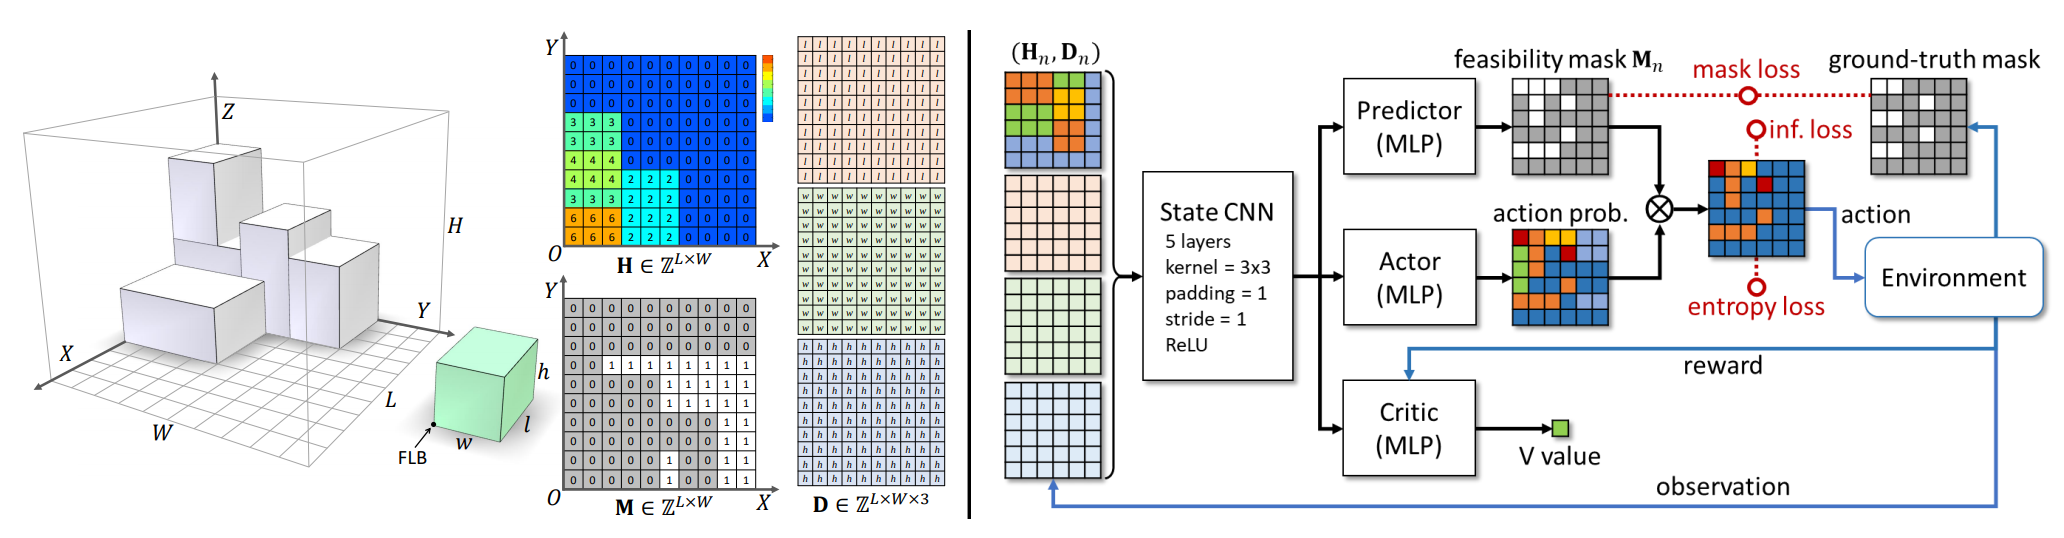

Nós fazemos as seguintes suposições:

* As caixas têm formato cúbico.
*  ordem das caixas não é conhecida a priori.
* Uma vez que uma caixa é colocada, o agente não pode movê-la.
* As caixas podem ser rotacionadas em ±90° apenas ao longo de três eixos.
* As dimensões são inteiras (menor escala 1cm).
* O agente pode ver n caixas futuras.
* As caixas só podem ser colocadas em um local se todos os cantos estiverem no * mesmo nível (chamado de viabilidade).
* Uma caixa não pode ser colocada abaixo de uma caixa já colocada.
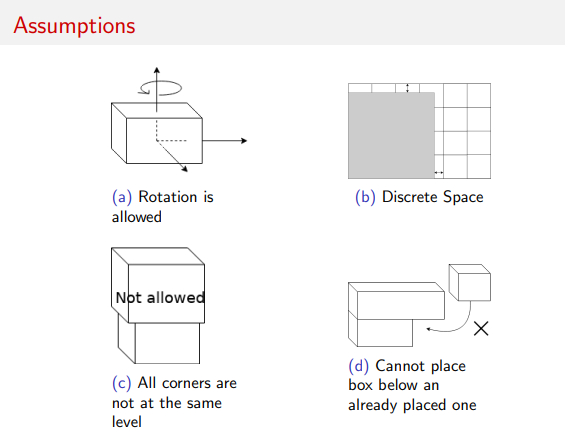

Nós denotamos alguns termos básicos de aprendizado por reforço usados.

* S: Estado
* A: Ação
* R: Recompensa
* π(s) ou π: Função que mapeia estados para ações
* Q(s, a): Função de valor Q ou função de valor de ação, que é a recompensa esperada se o agente estiver no estado (s) e tomar a ação (a)
* Nós tentamos maximizar a recompensa esperada.

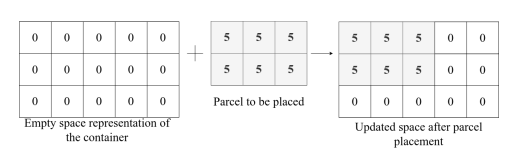

**Primeiro passo**: Coloque as caixas no primeiro local viável encontrado, varrendo do canto superior esquerdo do contêiner. Se não forem encontrados locais viáveis nos contêineres atualmente usados, a orientação da caixa é alterada e a pesquisa é executada novamente.

**Floor Building**: tenta embalar o contêiner camada por camada, do chão para cima. Portanto, procura efetivamente por posições com a menor altura h possível.

**Column Building**: tenta construir torres de caixas com a maior coordenada h viável no contêiner. Mas não é estável do ponto de vista da empilhabilidade do robô.

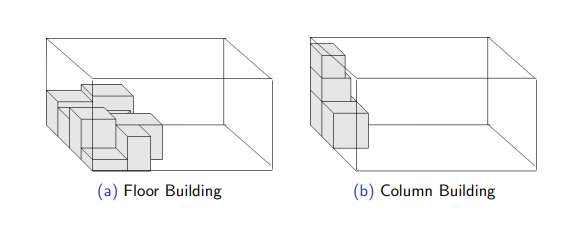

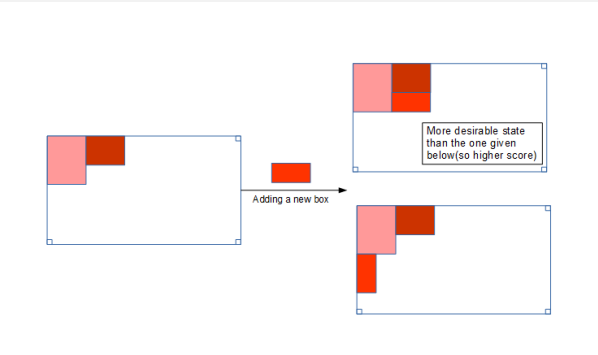

**A análise das informações apresentadas demonstra que a criação de um modelo de cubagem capaz de atender às necessidades de forma rápida e precisa é um desafio complexo. A ausência de detalhes sobre os caminhões, as caixas e a definição de regras específicas impede a construção de um modelo robusto e confiável. Para alcançar resultados satisfatórios em um ambiente real, seria imprescindível coletar dados mais precisos e aprofundar a análise dos requisitos do sistema.**

## Otimização do Tamanho de Embalagens

O problema envolve a definição de embalagens otimizadas para cada produto, minimizando:

* Custo de material: baseado no custo por unidade do material e no volume da embalagem.
* Custo de transporte: impactado pelo volume e peso da embalagem.

Vamos considerar que a embalagem deve ser suficientemente grande para acomodar o produto, porém, não muito maior para evitar desperdício. O custo total será uma combinação dos custos de material e transporte.

 * Volume do Produto: 𝑉𝑝=𝐴𝑙𝑡𝑢𝑟𝑎×𝐿𝑎𝑟𝑔𝑢𝑟𝑎×𝑃𝑟𝑜𝑓𝑢𝑛𝑑𝑖𝑑𝑎𝑑𝑒

 * Volume da Embalagem: Ve =(Altura+X)×(Largura+Y)×(Profundidade+Z)

 * Custo material da embalagem: Cm=Custo por unidade de material × Ve


Considerando que o custo de transporte pode ser influenciado diretamente pelo peso total da embalagem (produto + embalagem), uma função linear do peso pode ser usada.
 * Peso total: Pt=Peso do Produto+Peso da Embalagem.

### Restrições

* A embalagem deve ser suficientemente grande para caber o produto, ou seja
 * Altura embalagem ≥Altura produto
 * Largura embalagem ≥Largura produto
 * Profundidade embalagem ≥Profundidade produto


In [4]:
from scipy.optimize import minimize

# Criar dataframe a partir dos dados
df = pd.DataFrame(embalagens_data)

# Função para calcular o volume de um produto
def calcular_volume(altura, largura, profundidade):
    return altura * largura * profundidade

# Função de custo que será minimizada
def funcao_custo(margens, altura_prod, largura_prod, profundidade_prod, custo_material):
    margem_altura, margem_largura, margem_profundidade = margens

    # Calcular volume da embalagem (produto + margem)
    altura_emb = altura_prod + margem_altura
    largura_emb = largura_prod + margem_largura
    profundidade_emb = profundidade_prod + margem_profundidade

    volume_embalagem = altura_emb * largura_emb * profundidade_emb

    # Calcular o custo de material da embalagem
    custo_embalagem = volume_embalagem * custo_material

    # Assumindo um custo de transporte proporcional ao volume (pode-se ajustar)
    custo_transporte = volume_embalagem * 0.1  # custo fictício de transporte por volume

    return custo_embalagem + custo_transporte

# Função para otimizar a embalagem de cada produto
def otimizar_embalagem(altura_prod, largura_prod, profundidade_prod, custo_material):
    # Condições iniciais para as margens (arbitrárias, começar com 2 cm em cada direção)
    margens_iniciais = [2.0, 2.0, 2.0]

    # Restrições: margens devem ser positivas
    bounds = [(0.5, 10.0), (0.5, 10.0), (0.5, 10.0)]  # margens entre 0.5 cm e 10 cm

    # Usar o método de otimização 'minimize' para minimizar o custo
    resultado = minimize(
        funcao_custo,
        margens_iniciais,
        args=(altura_prod, largura_prod, profundidade_prod, custo_material),
        bounds=bounds,
        method='L-BFGS-B'
    )

    return resultado.x, resultado.fun  # Retorna as margens otimizadas e o custo

# Loop pelos produtos e otimizar suas embalagens
resultados = []
for i, row in df.iterrows():
    altura_prod = row["Altura"]
    largura_prod = row["Largura"]
    profundidade_prod = row["Profundidade"]
    custo_material = row["Custo por Unidade de Material"]

    margens_otimizadas, custo_total = otimizar_embalagem(
        altura_prod, largura_prod, profundidade_prod, custo_material
    )

    resultados.append({
        "ID do Produto": row["ID do Produto"],
        "Margem Altura": margens_otimizadas[0],
        "Margem Largura": margens_otimizadas[1],
        "Margem Profundidade": margens_otimizadas[2],
        "Custo Total Otimizado": custo_total
    })

# Exibir os resultados finais
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

    ID do Produto  Margem Altura  Margem Largura  Margem Profundidade  \
0               1            0.5             0.5                  0.5   
1               2            0.5             0.5                  0.5   
2               3            0.5             0.5                  0.5   
3               4            0.5             0.5                  0.5   
4               5            0.5             0.5                  0.5   
..            ...            ...             ...                  ...   
95             96            0.5             0.5                  0.5   
96             97            0.5             0.5                  0.5   
97             98            0.5             0.5                  0.5   
98             99            0.5             0.5                  0.5   
99            100            0.5             0.5                  0.5   

    Custo Total Otimizado  
0            25644.642431  
1            14889.553898  
2             7934.940981  
3          

Cada linha do DataFrame final contém as margens otimizadas de altura, largura e profundidade, além do custo total otimizado para cada produto.

 Calcula o volume do produto a partir das dimensões de altura, largura e profundidade.

  Calcula o custo total de uma embalagem, considerando o custo do material da embalagem e um custo de transporte (fictício). A função leva em consideração as margens de proteção

  Usa a função minimize da biblioteca scipy.optimize para otimizar as margens (espaço adicional para embalar o produto), com o objetivo de minimizar o custo total (material + transporte).

Para cada produto no DataFrame, otimiza as dimensões da embalagem, retornando as margens otimizadas e o custo total.

Os resultados são armazenados em um novo DataFrame e exibidos, mostrando as margens otimizadas e o custo total para cada produto.

### **Possíveis Melhorias**:
* Ajustar a função de custo de transporte para considerar variáveis mais realistas, como peso, volume ou rotas de transporte.
* Incluir outras restrições específicas, como robustez da embalagem para transporte seguro.

## Eficiência na Rota de Entregas

### **Definição do Problema**
O problema consiste em minimizar o tempo e o custo de entrega, levando em consideração:

* Distância: A distância entre o local de partida e o destino da entrega.
Tempo Estimado de Viagem: O tempo estimado pode ser influenciado pelas condições de tráfego.
* Condições de Tráfego: O tráfego pode ser Alto, Médio ou Baixo, e isso deve afetar o tempo total.

Modelo de Otimização
nosso objetivo é minimizar uma função de custo que combina o tempo de viagem com uma penalização por tráfego. Podemos ajustar o tempo estimado de viagem com base nas condições de tráfego para criar um fator de correção.

Fórmula geral para o tempo ajustado:
* Tempo Ajustado=Tempo Estimado de Viagem×(1+Fator de Trafego)

Onde:

* Tráfego Alto: Fator de Trafego=0.3 (30% mais lento),
* Tráfego Médio: Fator de Trafego=0.15(15% mais lento),
* Tráfego Baixo: Fator de Trafego=0 (sem atraso).

In [5]:
import pandas as pd
from scipy.optimize import linprog

# Criar dataframe a partir dos dados
df = pd.DataFrame(entregas_data)

# Definir fatores de tráfego
fatores_trafego = {
    "Alto": 0.3,   # 30% mais lento
    "Médio": 0.15,  # 15% mais lento
    "Baixo": 0.0   # Sem atraso
}

# Função para calcular o tempo ajustado com base no tráfego
def calcular_tempo_ajustado(tempo_estimado, condicao_trafego):
    fator = fatores_trafego[condicao_trafego]
    return tempo_estimado * (1 + fator)

# Adicionar coluna de tempo ajustado no DataFrame
df['Tempo Ajustado'] = df.apply(lambda row: calcular_tempo_ajustado(row['Tempo Estimado de Viagem'], row['Condições de Tráfego']), axis=1)

# Mostrar os dados com tempo ajustado
print("Dados com tempo ajustado:")
print(df[['ID da Entrega', 'ID do Veículo', 'Local de Partida', 'Destino da Entrega', 'Tempo Estimado de Viagem', 'Tempo Ajustado']])

# Otimização Linear para determinar a rota de menor tempo total
# No exemplo simples, vamos somar os tempos ajustados para todas as rotas e escolher o menor
# Pode ser expandido para mais veículos e destinos diferentes

# Função de otimização de rota para minimizar o tempo total
def otimizar_rotas(df):
    # Agrupar por veículo e calcular o tempo total ajustado
    tempos_totais = df.groupby('ID do Veículo')['Tempo Ajustado'].sum().reset_index()
    tempos_totais = tempos_totais.rename(columns={'Tempo Ajustado': 'Tempo Total'})

    # A melhor rota é a que tem o menor tempo total
    melhor_rota = tempos_totais.loc[tempos_totais['Tempo Total'].idxmin()]

    return melhor_rota

# Otimizar as rotas e encontrar a melhor
melhor_rota = otimizar_rotas(df)
print("\nMelhor rota otimizada:")
print(melhor_rota)

Dados com tempo ajustado:
    ID da Entrega ID do Veículo Local de Partida Destino da Entrega  \
0               1            V1              CD3            Local E   
1               2            V4              CD1            Local C   
2               3            V2              CD3            Local A   
3               4            V1              CD2            Local D   
4               5            V3              CD1            Local D   
..            ...           ...              ...                ...   
95             96            V2              CD2            Local D   
96             97            V3              CD1            Local A   
97             98            V2              CD2            Local A   
98             99            V3              CD2            Local A   
99            100            V3              CD2            Local C   

    Tempo Estimado de Viagem  Tempo Ajustado  
0                 129.517510      168.372763  
1                 150.63373



Calcula o tempo ajustado para cada rota, considerando o tempo estimado de viagem e as condições de tráfego. O fator de tráfego aumenta o tempo de viagem com base nas condições de tráfego ("Alto", "Médio", "Baixo").

Uma nova coluna é criada no DataFrame com os tempos ajustados para cada entrega.

Calcula o tempo total ajustado para cada veículo. A rota ideal será aquela em que o veículo tem o menor tempo total de entrega.

O código imprime as rotas com os tempos ajustados e indica qual veículo tem o tempo total mais eficiente.

## **Implementação e Teste**

1. Modelo de Capacidade dos Veículos:

Ao considerar a capacidade dos veículos, é necessário garantir que cada veículo seja capaz de carregar todas as entregas atribuídas a ele. Isso requer modelar tanto o peso quanto a cubagem (volume) de cada carga. Podemos usar restrições de capacidade para garantir que a soma do peso e volume das entregas não exceda os limites do veículo.

2. Modelo de Maximização de Cubagem



A cubagem (ou o uso eficiente do espaço no veículo) é um fator importante para otimizar as rotas de entrega. O modelo de cubagem visa maximizar a utilização do espaço disponível no veículo, minimizando o espaço vazio. Para isso, definimos um coeficiente de eficiência da cubagem 𝐸cubagem, que mede o quão bem o volume disponível do veículo é utilizado.

3. Integração do Modelo em um Ambiente Real:

A implementação do modelo em um ambiente operacional real envolve os seguintes passos:
* Integração com o Sistema de Gestão de Transporte (TMS): O modelo de otimização será integrado ao TMS da empresa, que contém informações sobre veículos, pedidos e rotas. O TMS será responsável por fornecer dados em tempo real sobre:

 * Localizações de partida e destino.
 * Condições de tráfego e estradas.
 * Capacidade dos veículos em termos de peso e volume.
 * Informações sobre pedidos (dimensões, peso, volume).

* O modelo, integrado ao TMS, calculará as rotas otimizadas e atribuirá veículos às rotas com base nas restrições de capacidade e cubagem.

* Validação do Modelo

* Testes Piloto: Implementar testes piloto em uma pequena parte da frota, comparando os resultados com as operações atuais. Serão observados aspectos como:
 * Tempo total de entrega.
 * Utilização de capacidade e cubagem dos veículos.
 * Custos operacionais (combustível, manutenção, horas de trabalho).



4. Validação da Eficácia:

A eficácia do modelo será validada comparando os resultados otimizados com os dados históricos de entregas. As principais métricas a serem analisadas incluem:

* Redução no Tempo Total de Entrega: Comparar o tempo de entrega otimizado com as operações anteriores.
* Redução de Custos Operacionais: Analisar os custos de combustível, manutenção e desgaste dos veículos após a implementação do modelo.
* Aumento da Eficiência de Cubagem: Monitorar o quanto o modelo maximiza a utilização do espaço disponível nos veículos.
* Conformidade com Restrições de Capacidade: Validar se os veículos nunca ultrapassam a capacidade de peso e volume.




## **Monitoramento**

Após a implementação, o desempenho do modelo precisaria ser monitorado continuamente para garantir que ele esteja funcionando de forma eficiente e adaptado a mudanças no ambiente de operação .

1. Métricas de Monitoramento:

As principais métricas para monitorar o desempenho do modelo incluem:

* Tempo Médio de Entrega:

 * Monitorar o tempo médio de entrega de todas as rotas.
 * Comparar o tempo médio de entrega após a implementação do modelo com dados históricos.
* Eficiência de Cubagem:

 * Acompanhar a utilização do espaço em cada veículo.
 * Avaliar a proporção de veículos com alta utilização de cubagem (ex: acima de 85% de ocupação).
* Custo de Combustível por Rota:

 * Monitorar o consumo de combustível em cada rota.
 * Avaliar se houve redução nos custos de combustível devido à otimização de rotas mais curtas ou menos tempo em trânsito.
* Cumprimento dos Prazos de Entrega:

 * Acompanhar o percentual de entregas que chegam no prazo.
 * Analisar o impacto das condições de tráfego nos prazos de entrega.
* Uso da Capacidade de Peso:

 * Verificar se os veículos estão sendo carregados adequadamente sem ultrapassar a capacidade de peso.
* Rotas Eficientes vs Ineficientes:

 * Identificar as rotas que ainda apresentam problemas de eficiência após a otimização, como tempos de viagem muito altos ou baixa utilização de cubagem.




2. Alertas e Ajustes em Tempo Real:

O modelo será ajustado em tempo real com base nas seguintes situações:

* Mudanças nas Condições de Tráfego: Caso haja um aumento no tráfego em determinadas rotas, o sistema ajustará automaticamente os cálculos de tempo e sugerirá alternativas.
* Sobrecarga de Veículos: Se for detectada uma sobrecarga de peso ou volume no veículo, o sistema redistribuirá as cargas para outros veículos.
* Falhas Operacionais: Caso algum veículo tenha falha mecânica, o sistema recalculará as rotas para reatribuir as entregas pendentes a outros veículos.




3. Relatórios e Painéis de Desempenho

Para garantir o monitoramento contínuo do desempenho, serão gerados relatórios periódicos com base nas métricas mencionadas. Painéis (dashboards) em tempo real poderão ser utilizados para visualizar:

* Roteiros ativos.
* Tempo médio de entrega por rota.
* Utilização da cubagem e da capacidade dos veículos.
* Custos operacionais em tempo real (combustível, horas trabalhadas).






4. Ajuste Contínuo do Modelo

* Treinamento Contínuo: O modelo será ajustado e re-treinado conforme novos dados de entrega, condições de tráfego e informações dos veículos forem coletados.
* Feedback do Operador: Feedback dos motoristas e operadores logísticos será coletado para identificar problemas com rotas otimizadas, garantindo que o modelo seja prático e eficiente.

## **Conclusão**

A implementação do modelo de Otimização de Rotas de Entrega com restrições de capacidade de veículos e maximização de cubagem pode gerar ganhos significativos em termos de custo, tempo de entrega e eficiência operacional. O monitoramento contínuo das métricas garantirá que o modelo mantenha a eficácia em um ambiente dinâmico, ajustando-se em tempo real para oferecer a melhor solução logística.